### Data and dependencies

In [1]:
#importing libraries
import tensorflow as tf
import numpy as np
from tensorflow import keras 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class BatchDataGenerator(keras.utils.Sequence):
    def __init__(self,dataset_path,length,batch_size=64,start_idx=0,pad=1):
        self.dataset_path=dataset_path
        self.length=length
        self.batch_size=batch_size
        self.start_idx=start_idx
        self.paddings=tf.constant([[0,0], [pad,0], [0,0]])
    def __len__(self):
        return self.length
    def __getitem__(self,idx,labels_only=False):
        loaded = np.load(str(self.dataset_path+'/batch_'+str(int(self.start_idx+idx+1))+'.npz'))
        array1 = loaded['array1_drm']
        array2 = loaded['array2_pia']
        array3 = loaded['array3_gtr']
        array4 = loaded['array4_bss']
        dec_input = tf.slice(tf.pad(array1,paddings=self.paddings),[0,0,0],array1.shape)
        inputs = [
            array2,array3,array4,
            dec_input[:,:,:9],
            dec_input[:,:,9:18],
            dec_input[:,:,18:27]
        ]
        targets =[
            array1[:,:,:9],
            array1[:,:,9:18],
            array1[:,:,18:27]
        ]
        if labels_only:
            return targets
        else:
            return inputs,targets

# Model


> ## Defining the model

In [3]:
#hyperparameters

units1_1,units1_2,units1_3 = 200,200,200

units2 = 450
latent_units = 300

units3_1, units3_2 = 256,256 

units4 = 9                      #original_dim

#-----
epochs=100
batch_size=64
#lr = 1e-3
#opt = keras.optimizers.Adam(learning_rate=lr,decay=0.1,clipvalue=4.0)

mse = keras.losses.MeanSquaredError()

val_ratio = 0.25
test_ratio = 0.05 
dataset_ratio = 0.3

In [4]:
dataset_length=8707*dataset_ratio
train_length= int((1-val_ratio-test_ratio)*dataset_length)
val_length= int(val_ratio*dataset_length)
test_length= int(dataset_length-train_length-val_length)
print(train_length)
print(val_length)
print(test_length)
dataset_path = '../datasets/data_for_sequence'

dataset_train = BatchDataGenerator(dataset_path=dataset_path,length=train_length)
dataset_val = BatchDataGenerator(dataset_path=dataset_path, length=val_length, start_idx=train_length)
dataset_test = BatchDataGenerator(dataset_path=dataset_path,length=test_length,start_idx=train_length+val_length)

1828
653
131


In [5]:
# custom layers and functions for the model

def weighted_crossentropy(y_true,y_pred): 
    return y_true * -keras.backend.log(y_pred) * 3 * (1-y_pred)*2 + (1 - y_true) * -keras.backend.log(1 - y_pred) * y_pred*2

class Sampling(keras.layers.Layer):
    def call(self,inputs):
        z_mean,z_log_var=inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = keras.backend.random_normal(shape=(batch,dim))
        return z_mean + tf.exp(0.5*z_log_var) * epsilon

class KL_Divergence(keras.layers.Layer):
    def call(self,inputs):
        z_mean,z_log_var=inputs
        return -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)

class ConductorRNN(keras.layers.Layer):
    def __init__(self,units=256,name='conductorRNN',has_splits=True,num_splits=4,**kwargs):
        super(ConductorRNN,self).__init__(name=name,**kwargs)
        self.num_splits=num_splits
        self.lstm_cell = layers.LSTMCell(units)
        self.split_length=int(128/num_splits)
    def call(self,x):
        predictions=[]
        state=self.lstm_cell.get_initial_state(x)
        for i in range(self.num_splits):
            x,state = self.lstm_cell(x,states=state)
            predictions.append(x)
        return predictions
        
class RNN_Helper(keras.layers.Layer):
    # i created this to clean off the input preparation following the conductorRNN output
    # it was messing up the graphs and making them unreadable due to too many instances of RepeatVector and Concatenate
    def __init__(self,split_length=32,name='helper'):
        super(RNN_Helper,self).__init__(name=name)
        self.repeat = layers.RepeatVector(split_length)
        self.concat = layers.Concatenate(axis=2)
    def call(self,dec_input,c):
        return self.concat([dec_input,self.repeat(c)])


class State_Embedder(keras.layers.Layer):
    def __init__(self,units=256,name='state_Embedder',**kwargs):
        super(State_Embedder,self).__init__(name=name,**kwargs)
        self.dense=layers.Dense(units*2,activation='tanh')
    def call(self,c):
        c=self.dense(c)
        return tf.split(c,2,axis=1)

class Input_Splitter(keras.layers.Layer):
    def __init__(self,num_splits=4):
        super(Input_Splitter,self).__init__()
        self.num_splits=num_splits
    def call(self,input):
        return tf.split(input,num_splits,axis=1)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             [(64, 128, 128)]     0                                            
__________________________________________________________________________________________________
input2 (InputLayer)             [(64, 128, 128)]     0                                            
__________________________________________________________________________________________________
input3 (InputLayer)             [(64, 128, 128)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (64, 32, 32)         16416       input1[0][0]                     
_______________________________________________________________________________________

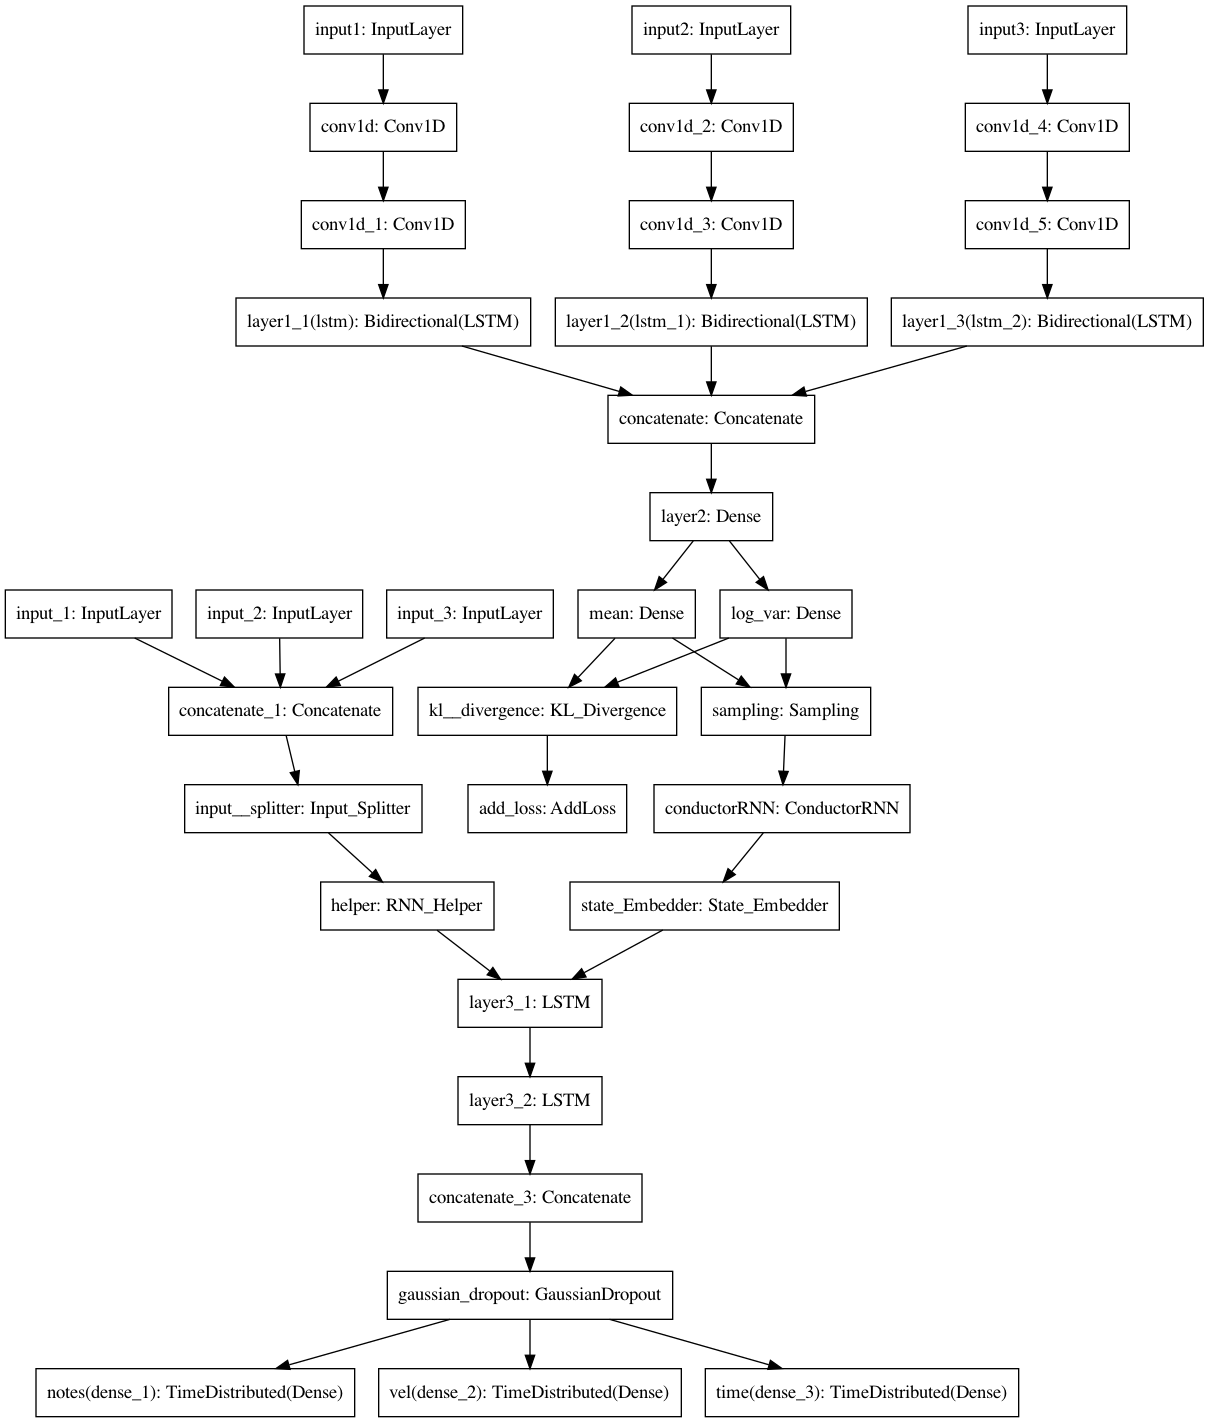

In [6]:
#model
from keras import layers
from keras.layers import LSTM
from keras.layers import TimeDistributed as TD
from keras.layers import Bidirectional as BD
from keras.layers import Input

#encoder
# inputs
input_layer1 = Input(shape=(128,128),batch_size=batch_size,name='input1')
input_layer2 = Input(shape=(128,128),batch_size=batch_size,name='input2')
input_layer3 = Input(shape=(128,128),batch_size=batch_size,name='input3')

model_encoder_inputs=[input_layer1,input_layer2,input_layer3]
# Bidirectional CNN-LSTM for each instrument 
conv_layer1_1= layers.Conv1D(filters=32,kernel_size=4,strides=4)(input_layer1) 
conv_layer1_2= layers.Conv1D(filters=64,kernel_size=4,strides=2)(conv_layer1_1) 

conv_layer2_1= layers.Conv1D(filters=32,kernel_size=4,strides=4)(input_layer2) 
conv_layer2_2= layers.Conv1D(filters=64,kernel_size=4,strides=2)(conv_layer2_1) 

conv_layer3_1= layers.Conv1D(filters=32,kernel_size=4,strides=4)(input_layer3) 
conv_layer3_2= layers.Conv1D(filters=64,kernel_size=4,strides=2)(conv_layer3_1) 

layer1_1 = BD(LSTM(units1_1),name='layer1_1')(conv_layer1_2)
layer1_2 = BD(LSTM(units1_2),name='layer1_2')(conv_layer2_2)
layer1_3 = BD(LSTM(units1_3),name='layer1_3')(conv_layer3_2)

concat_layer = layers.Concatenate(axis=1)([layer1_1,layer1_2,layer1_3])

layer2 = layers.Dense(units2,activation='tanh',name='layer2')(concat_layer)

# VIB (Variational Information Bottleneck)
z_mean = layers.Dense(latent_units,name='mean')(layer2)       # means 
z_log_var = layers.Dense(latent_units,name='log_var')(layer2) # covariance matrices
z = Sampling()([z_mean,z_log_var])

####################################
####################################
#decoder
model_decoder_input1 = Input(shape=(128,9),batch_size=batch_size)
model_decoder_input2 = Input(shape=(128,9),batch_size=batch_size)
model_decoder_input3 = Input(shape=(128,9),batch_size=batch_size)

model_decoder_inputs=[model_decoder_input1, model_decoder_input2, model_decoder_input3]
model_decoder_in = layers.Concatenate(axis=2)(model_decoder_inputs)

# desiging decoder to accept subsequences 
num_splits=4
split_length=int(128/num_splits)

model_decoder_in = Input_Splitter(num_splits=num_splits)(model_decoder_in) #4 subsequences
c_embeddings = ConductorRNN(units=z.shape[1])(z) 

helper = RNN_Helper(split_length)
embedder = State_Embedder(units=units3_1)
layer3_1 = LSTM(units3_1,return_sequences=True,name='layer3_1')
layer3_2 = LSTM(units3_2,return_sequences=True,name='layer3_2')

# iterating decoder over each subsequence
dec_outputs=[]
for split,c in enumerate(c_embeddings):
    x= helper(model_decoder_in[split],c)
    output=layer3_1(x,initial_state=embedder(c))
    output=layer3_2(output)
    dec_outputs.append(output) #one output per subsequence

layer3_out = layers.Concatenate(axis=1)(dec_outputs)

# dropout layer
drop = layers.GaussianDropout(0.25)(layer3_out)

# outputs
output1 = TD(layers.Dense(9,activation='sigmoid'),name='notes')(drop)
output2 = TD(layers.Dense(9,activation='sigmoid'),name='vel')(drop)
output3 = TD(layers.Dense(9,activation='tanh'),name='time')(drop)
model_outputs = [output1,output2,output3]

# defining model
model = keras.Model([model_encoder_inputs,model_decoder_inputs],model_outputs)

KL_loss = KL_Divergence()([z_mean,z_log_var])
model.add_loss(KL_loss)

model.summary()
tf.keras.utils.plot_model(model)

> ## Training the model



In [7]:
def call_compile(lr=1e-3):
    global model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr,decay=0.1,clipvalue=4.0),
        loss={
            'notes':weighted_crossentropy,
            'vel':mse,
            'time':mse
            },
        metrics={
            'notes':['BinaryAccuracy','Precision','Recall'],
        }
    )

In [8]:
logdir='logs'
filepath='model_checkpoints/tm-model'

In [9]:
#when resuming training:
#model.load_weights(filepath)

In [10]:
!rm -rf logs
!mkdir logs

In [11]:
!rm -rf model_checkpoints
!mkdir model_checkpoints

In [12]:
class EpochTracker(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        global ep_tracker
        ep_tracker=epoch

In [13]:
def call_fit(initial_epoch,epochs_to_run):
    global model
    model.fit(
        initial_epoch=initial_epoch,
        x=dataset_train,
        batch_size=batch_size,
        epochs=epochs_to_run,
        verbose=1,
        validation_data=dataset_val,
        callbacks = [
            keras.callbacks.TensorBoard(
                log_dir=logdir,
                histogram_freq=1,
                write_graph=False,
                write_images=False,
            ),
            keras.callbacks.ModelCheckpoint(
                filepath,
                monitor='val_loss',
                save_best_only=True,
                save_weights_only=True,
                mode='min'
            ),
            keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.1,
            patience=5,
            verbose=1,
            min_delta=1e-3,
            mode='min'
            ),
            keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=8,
                verbose=1,
                mode='min',
                restore_best_weights=True
            ),
            keras.callbacks.TerminateOnNaN(),
            EpochTracker(),     
        ]
    )

In [14]:
def apply_schedule(sched):
    global model
    i=0
    for layer in model.layers:
        if len(layer.trainable_weights)>0:
            if i in sched[0]:
                layer.trainable=False
            else:
                layer.trainable=True
            i+=1

In [15]:
"""shows layers to freeze and for how many epochs
"""
schedule = [
    [[],8,1e-3], #everything, 8 epochs 
    [range(0,9),5,1e-3], #no encoder, 5 epochs 
    [[0,1,2,3,4,5,14,15,16,17,18],5,5e-4], #middle active, 5 epochs 
    [range(10,19),7,5e-4], #encoder active, 7 epochs
    [range(14,19),5,1e-4], #up to middle active, 5 epochs
    [[],10,7e-5], #full model, 10 epochs, lower lr 
    [[],20,1e-5], #full model, 10 epochs, lower lr 
]
#60 epochs total

In [17]:
#custom training loop:
curr_epoch=0
for idx in range(len(schedule)):
    print(f'\ttraining part {idx+1}:')
    apply_schedule(schedule[idx])
    call_compile(schedule[idx][2])
    call_fit(curr_epoch,curr_epoch+schedule[idx][1])
    curr_epoch=ep_tracker #incrementing curr epoch 


	training part 1:
Epoch 1/8
   1/1828 [..............................] - ETA: 0s - loss: 1.0718 - notes_loss: 0.8316 - vel_loss: 0.2356 - time_loss: 0.0039 - notes_binary_accuracy: 0.4606 - notes_precision: 0.0869 - notes_recall: 0.4956WARNING:tensorflow:From /Users/boby/Documents/school stuff/TM/jupyter_tests/venv/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1828/1828 [==============================] - 3298s 2s/step - loss: 0.5624 - notes_loss: 0.4871 - vel_loss: 0.0470 - time_loss: 0.0222 - notes_binary_accuracy: 0.8835 - notes_precision: 0.4353 - notes_recall: 0.4521 - val_loss: 0.5377 - val_notes_loss: 0.4859 - val_vel_loss: 0.0442 - val_time_loss: 0.0022 - val_notes_binary_accuracy: 0.8929 - val_notes_precision: 0.4857 - val_notes_recall: 0.4259
Epoch 2/8
1828/1828 [====================

KeyboardInterrupt: 

## Plotting results (Histograms)

In [16]:
%load_ext tensorboard
%tensorboard --logdir logs

Reusing TensorBoard on port 6007 (pid 47440), started 11:17:45 ago. (Use '!kill 47440' to kill it.)

In [27]:
def get_test_labels(dataset_test):
    for batch in range(dataset_test.__len__()):
        if batch==0:
            array=dataset_test.__getitem__(batch,labels_only=True)[0]
        else:
            array = np.concatenate([array,dataset_test.__getitem__(batch,labels_only=True)[0]],axis=0)
    return array

In [28]:
import random as r
def plot_instruments(batch=None):
    print('getting predictions...')
    predictions,_,_ = model.predict(dataset_test)
    print('getting labels...')
    labels = get_test_labels(dataset_test)

    instruments=['kick','snare','hi-hat closed','hi-hat open','tom3','tom2','tom1','ride','crash']
    for instr,name in enumerate(instruments):
        print(name)
        
        positives=[]
        negatives=[]
        for sample in range(predictions.shape[0]):
            for t in range(predictions.shape[1]):
                if labels[sample,t,instr]==1:
                    positives.append(predictions[sample,t,instr])
                else:
                    negatives.append(predictions[sample,t,instr])
        
        sns.histplot(positives,kde=True,color='blue',fill=False,)
        sns.histplot(negatives,kde=True,color='red',fill=False)
        plt.legend(('positives','negatives'))
        plt.plot()
        plt.show()

In [29]:
def plot_values(hist=False):
    print('gettting predictions...')
    predictions,_,_ = model.predict(dataset_test)
    print('getting labels...')
    labels = get_test_labels(dataset_test)

    positives=[]
    negatives=[]
    print('comparing...')
    for sample in range(predictions.shape[0]):
        for t in range(predictions.shape[1]):
            for instr in range(predictions.shape[2]):
                if labels[sample,t,instr]==1:
                    positives.append(predictions[sample,t,instr])
                else:
                    negatives.append(predictions[sample,t,instr])
    print('creating plot...')
    sns.kdeplot(positives,shade=True,legend=True)
    sns.kdeplot(negatives,shade=True,legend=True)
    plt.legend(('positives','negatives'))
    plt.plot()
    plt.show()
    #--------------------
    if hist:
        h_name=[]
        h_val=[]
        for var in history.history:
            h_name.append(var)
            h_val.append(history.history[var])


        l = int(len(h_name)/2)

        for i in range(l):
            plt.plot(h_val[i],label=h_name[i])
            plt.plot(h_val[i+l],label=h_name[i+l])
            plt.legend()
            plt.show()

getting predictions...
getting labels...
kick


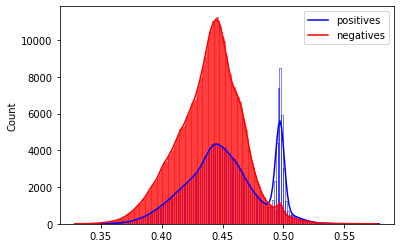

snare


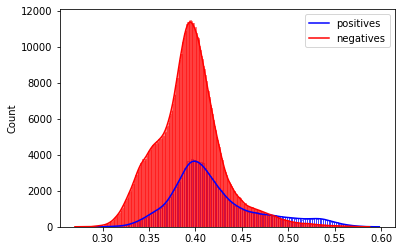

hi-hat closed


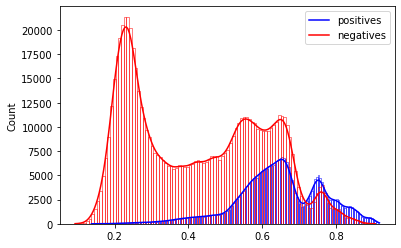

hi-hat open


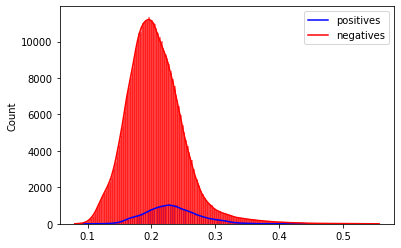

tom3


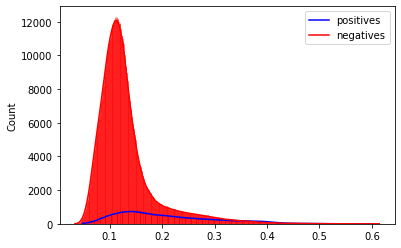

tom2


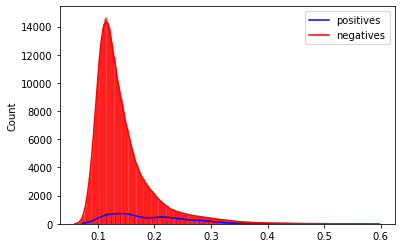

tom1


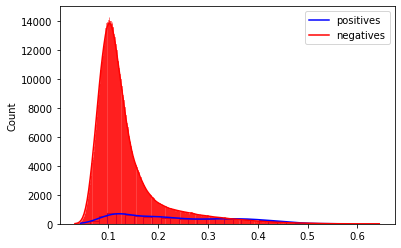

ride


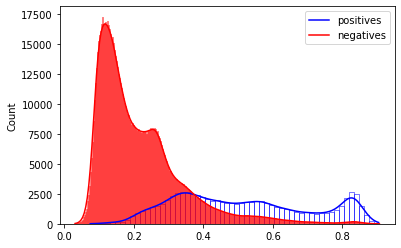

crash


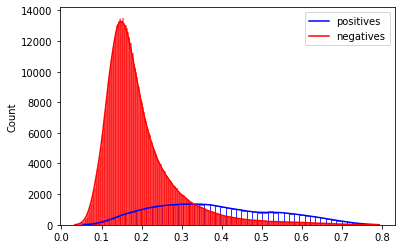

In [30]:
plot_instruments()

gettting predictions...
getting labels...
comparing...
creating plots...


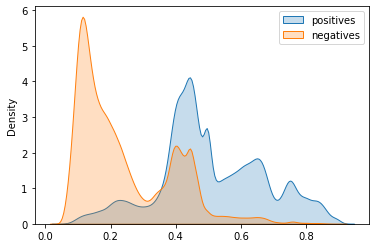

In [31]:
plot_values()